In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE, ConvNeXtBlock1D


/home/nwertheim/miniconda3/bin/python


In [5]:
# Set hyperparameters
num_epochs = 5
num_blocks = 5
kernel_size = 9
base_dim = 128
learning_rate = 3.57844559759971e-05
batch_size = 16

In [6]:
train_file = os.path.join(univariate_data_path, 'merged_univariate_no_PCA_train.npy')
train_data = np.load(train_file, allow_pickle=True)
test_file = os.path.join(univariate_data_path, 'merged_univariate_no_PCA_test.npy')
test_data = np.load(test_file, allow_pickle=True)
print(train_data.shape)
print(test_data.shape)

print(train_data[0]['signal'].shape)
print(train_data[0])



(4003,)
(1171,)
(33060, 1)
{'record_name': 'icehg956-chan0', 'signal': array([[ 3.15242801],
       [ 2.93295337],
       [ 2.72134811],
       ...,
       [-0.50079448],
       [-0.52595218],
       [-0.54716481]]), 'metadata': {'fs': 20, 'sig_len': 35460, 'n_sig': 6, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['S1', 'S1_DOCFILT-4-0.08-5', 'S2', 'S2_DOCFILT-4-0.08-5', 'S3', 'S3_DOCFILT-4-0.08-5'], 'comments': ['Comments:', 'RecID 956', 'RecType Induced', 'Gestation 40', 'Rectime 30.3', 'Age 28', 'Weight 82', 'Placental_position end', 'Height 173', 'Newborn_weight 3350', 'Pair_RecID 958']}}


In [7]:
import numpy as np
import pandas as pd

# Function to create time windows from the signal data
def create_time_windows(data, window_length=12000, step_size=12000):
    """
    Create sliding windows of a specified length and step size from a list of signals.

    Args:
        data: list of dicts, each containing a 'signal' array of shape (seq_len, 1)
        window_length: number of time steps in each window
        step_size: number of time steps to move between windows (for overlap)

    Returns:
        np.ndarray: shape (num_windows, window_length), univariate windows
    """
    windows = []

    for entry in data:
        signal = entry['signal'].flatten()  # shape: (seq_len,)
        signal_length = len(signal)

        if signal_length < window_length:
            continue

        for start_idx in range(0, signal_length - window_length + 1, step_size):
            end_idx = start_idx + window_length
            window = signal[start_idx:end_idx]
            windows.append(window)

    return np.array(windows)  # shape: (num_windows, window_length)


X_train = create_time_windows(train_data)
X_test = create_time_windows(test_data)
print(X_train.shape)
print(X_test.shape)

(9669, 12000)
(3179, 12000)


In [8]:
def mask_data(x, mask_ratio=0.75, patch_size=8):
    """
    Apply patch-based masking to a batch of univariate time series.

    Args:
        x: np.ndarray of shape (num_windows, window_length)
        mask_ratio: float, fraction of patches to mask
        patch_size: int, number of time steps in each patch

    Returns:
        np.ndarray: masked version of x with same shape
    """
    x_masked = np.copy(x)
    num_windows, window_length = x.shape
    num_patches = window_length // patch_size

    for i in range(num_windows):
        mask = np.random.rand(num_patches) < mask_ratio
        for j in range(num_patches):
            if mask[j]:
                start = j * patch_size
                end = (j + 1) * patch_size
                x_masked[i, start:end] = 0  # or np.nan if you prefer

    return x_masked

# Apply masking to train, validation, and test sets
mask_ratio = 0.75  # Adjust this to your desired masking ratio
masked_X_train = mask_data(X_train, mask_ratio)
masked_X_test = mask_data(X_test, mask_ratio)

# Check the shape of the masked datasets
print(f"Masked Training set shape: {masked_X_train.shape}")
print(f"Masked Test set shape: {masked_X_test.shape}")

Masked Training set shape: (9669, 12000)
Masked Test set shape: (3179, 12000)


In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Define batch size
batch_size = batch_size

# Convert to tensors (still on CPU at this point)
masked_X_train_tensor = torch.tensor(masked_X_train, dtype=torch.float32).unsqueeze(1)
unmasked_X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)

masked_X_test_tensor = torch.tensor(masked_X_test, dtype=torch.float32).unsqueeze(1)
unmasked_X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets with both masked and unmasked tensors
train_dataset = TensorDataset(masked_X_train_tensor, unmasked_X_train_tensor)
test_dataset = TensorDataset(masked_X_test_tensor, unmasked_X_test_tensor)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



=== Run 1/5 ===



=== Run 2/5 ===

=== Run 3/5 ===

=== Run 4/5 ===

=== Run 5/5 ===


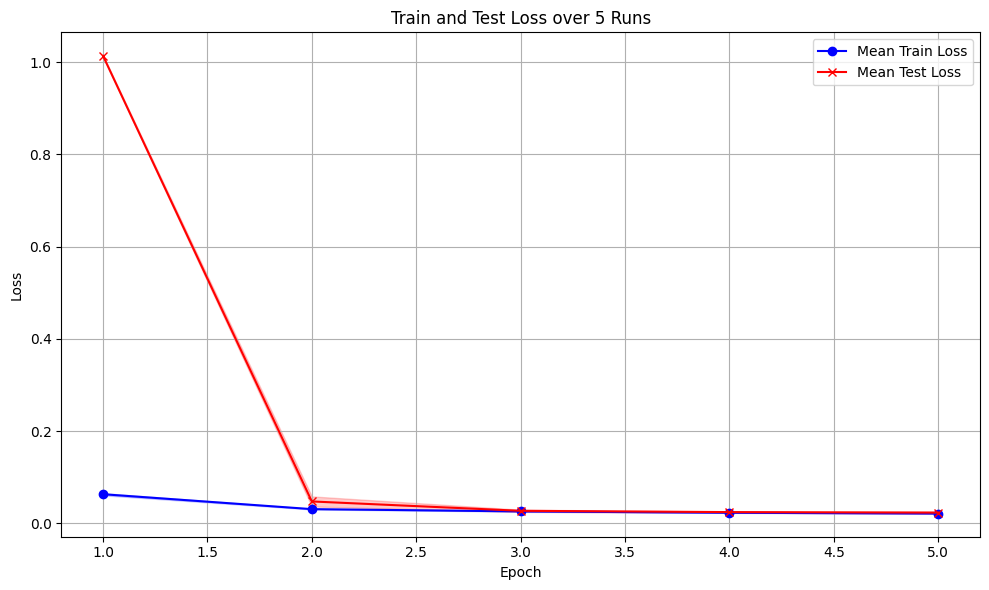


Final Test Loss per run:
Run 1: Final Test Loss = 0.0242
Run 2: Final Test Loss = 0.0196
Run 3: Final Test Loss = 0.0221
Run 4: Final Test Loss = 0.0228
Run 5: Final Test Loss = 0.0273

Average Final Test Loss: 0.0232
Std of Final Test Loss: 0.0025

Best model was from Run 2 with Final Test Loss = 0.0196
Model encoder saved to ../models/FCMAE_encoder_no_PCA_gpu.pth


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Set random seeds for more reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

num_repeats = 5  # How many times to repeat training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate_once():
    model = FCMAE(in_channels=1, base_dim=base_dim, num_blocks=num_blocks, kernel_size=kernel_size)

    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # --- EVALUATE ---
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for masked_input, original_input in test_loader:
                masked_input = masked_input.to(device)
                original_input = original_input.to(device)

                reconstructed = model(masked_input)
                loss = criterion(reconstructed, original_input)
                test_loss += loss.item()

            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        for masked_input, original_input in train_loader:
            masked_input = masked_input.to(device)
            original_input = original_input.to(device)

            reconstructed = model(masked_input)
            loss = criterion(reconstructed, original_input)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

    return train_losses, test_losses, model


# Store all runs
all_train_losses = []
all_test_losses = []
final_test_losses = []
models = []

for run in range(num_repeats):
    print(f"\n=== Run {run+1}/{num_repeats} ===")
    train_losses, test_losses, model = train_and_evaluate_once()
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    final_test_losses.append(test_losses[-1])
    models.append(model)

# Convert to numpy arrays for easier computation
all_train_losses = np.array(all_train_losses)
all_test_losses = np.array(all_test_losses)
final_test_losses = np.array(final_test_losses)

# Compute mean and std
mean_train_losses = np.mean(all_train_losses, axis=0)
std_train_losses = np.std(all_train_losses, axis=0)
mean_test_losses = np.mean(all_test_losses, axis=0)
std_test_losses = np.std(all_test_losses, axis=0)

# --- Plotting ---
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_train_losses, label="Mean Train Loss", color="blue", marker='o')
plt.fill_between(epochs, 
                 mean_train_losses - std_train_losses, 
                 mean_train_losses + std_train_losses, 
                 color="blue", alpha=0.2)

plt.plot(epochs, mean_test_losses, label="Mean Test Loss", color="red", marker='x')
plt.fill_between(epochs, 
                 mean_test_losses - std_test_losses, 
                 mean_test_losses + std_test_losses, 
                 color="red", alpha=0.2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Train and Test Loss over {num_repeats} Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print summary ---
print("\nFinal Test Loss per run:")
for i, loss in enumerate(final_test_losses):
    print(f"Run {i+1}: Final Test Loss = {loss:.4f}")

print(f"\nAverage Final Test Loss: {np.mean(final_test_losses):.4f}")
print(f"Std of Final Test Loss: {np.std(final_test_losses):.4f}")

# --- Saving the best model ---
best_run_idx = np.argmin(final_test_losses)  # Run with lowest final test loss
best_model = models[best_run_idx]

# Save only the encoder part
encoder_path = os.path.join(models_path, 'FCMAE_encoder_no_PCA_gpu.pth')
torch.save(best_model.state_dict(), encoder_path)

print(f"\nBest model was from Run {best_run_idx+1} with Final Test Loss = {final_test_losses[best_run_idx]:.4f}")
print(f"Model encoder saved to {encoder_path}")
